In [1]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [2]:
def classical_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                          risk_free_interest_rate, dividend_rate, 
                          volatility, option_type, time_steps_count, samples_count):
    
    rate_difference = risk_free_interest_rate - dividend_rate
    
    # Stock prices
    
    time_step = time_to_maturity/time_steps_count
    
    weights = np.random.standard_normal(size=(samples_count, time_steps_count))
    
    samples = weights.sum(axis=1) * np.sqrt(time_step)  

    stock_prices = initial_stock_price * np.exp((rate_difference - 0.5 * volatility ** 2) * time_to_maturity 
                                                + volatility * samples)
    
    # Option prices
    
    price_differences = stock_prices - strike_price   
    
    if option_type == 'Put':
        price_differences = -price_differences
    
    # price_differences[price_differences < 0] = 0
    
    price_differences = np.clip(price_differences, a_min=0, a_max=None)
    
    option_prices = price_differences * np.exp(-risk_free_interest_rate * time_to_maturity)
         
    return option_prices


def plot_asset_prices(initial_asset_prices, volatilities, asset_prices_meshgrid,
                       elevation=10, initial_azimuth=230):

    initial_asset_prices_grid, volatilities_grid = np.meshgrid(initial_asset_prices, volatilities)

    fig, ax = plt.subplots(figsize=(5, 5),
                           subplot_kw={"projection": "3d"})

    surface = ax.plot_surface(initial_asset_prices_grid,
                              volatilities_grid,
                              asset_prices_meshgrid.T,
                              cmap='plasma',
                              linewidth=30, 
                              antialiased=False)

    ax.view_init(elev=elevation, azim=initial_azimuth)

    ax.zaxis.set_rotate_label(False)
    
    ax.set_xlabel('Initial Asset Price')
    ax.set_ylabel('Volatility')
    ax.set_zlabel('Asset Price', rotation=90)
    
    plt.show()

    
def jax_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                    risk_free_interest_rate, dividend_rate, 
                    volatility, option_type, time_steps_count, samples_count,
                    randomization_key):
    
    rate_difference = risk_free_interest_rate - dividend_rate
    
    # Stock prices
    
    time_step = time_to_maturity/time_steps_count
    
    weights = jax.random.normal(key=randomization_key, 
                                shape=(samples_count, time_steps_count))
    
    # weights = jnp.zeros((samples_count, time_steps_count))
    
    samples = weights.sum(axis=1) * jnp.sqrt(time_step)  

    stock_prices = initial_stock_price * jnp.exp((rate_difference - 0.5 * volatility ** 2) * time_to_maturity 
                                                 + volatility * samples)
    
    # Option prices
    
    price_differences = stock_prices - strike_price   
    
    if option_type == 'Put':
        price_differences = -price_differences
    
    price_differences = jnp.clip(price_differences, a_min=0)
    
    option_prices = price_differences * jnp.exp(-risk_free_interest_rate * time_to_maturity)
         
    return option_prices


# def meanify(function):
    
#     def function_mean(*args, **kwargs):
        
#         function_result = function(*args, **kwargs)
        
#         mean_result = function_result.mean()
        
#         return mean_result
    
#     return function_mean
    

def jax_monte_carlo_mean(initial_stock_price, strike_price, time_to_maturity, 
                         risk_free_interest_rate, dividend_rate, 
                         volatility, option_type, time_steps_count, samples_count,
                         randomization_key):
    
    samples = jax_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                              risk_free_interest_rate, dividend_rate, 
                              volatility, option_type, time_steps_count, samples_count,
                              randomization_key)
    
    result = samples.mean()
    
    return result


def classical_monte_carlo_mean(initial_stock_price, strike_price, time_to_maturity, 
                               risk_free_interest_rate, dividend_rate, 
                               volatility, option_type, time_steps_count, samples_count):
    
    samples = classical_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                                    risk_free_interest_rate, dividend_rate, 
                                    volatility, option_type, time_steps_count, samples_count)
    
    result = samples.mean()
    
    return result

In [3]:
# Fixed Parameters

T = time_to_maturity = 1

q = dividend_rate = 0.05
r = risk_free_interest_rate = 0.02

time_steps_count = 300

strike_price = 1000

samples_count = 100

CallPut = option_type = 'Call'

### Jax

In [4]:
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [5]:
import os
import time
import numpy as np

# JAX

import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)


# Host CPUs

# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=16'

# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(1, 3)))

jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=4, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=5, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=6, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=7, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=8, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=9, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=10, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=11, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=12, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=13, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=14, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=15, pro

In [6]:
jitted_monte_carlo = jax.jit(jax_monte_carlo, 
                             static_argnames=('samples_count' , 
                                              'time_steps_count',
                                              'option_type'))

jitted_monte_carlo_mean = jax.jit(jax_monte_carlo_mean, 
                                  static_argnames=('samples_count' , 
                                                   'time_steps_count',
                                                   'option_type'))

In [7]:
samples_count = 10000

STOCK_PRICE_STEPS = 16
VOLATILITY_STEPS = 16

initial_stock_prices = np.linspace(0, 10000, STOCK_PRICE_STEPS)

volatilities = np.linspace(0, 1.0, VOLATILITY_STEPS)

initial_stock_prices_count = len(initial_stock_prices)
volatilities_count = len(volatilities)


# Randomization Keys

random_seed = np.random.randint(1000)

initial_randomization_key = jax.random.PRNGKey(seed=random_seed)

keys_count = volatilities_count * initial_stock_prices_count

randomization_keys_vector = jax.random.split(initial_randomization_key, keys_count)

randomization_keys = randomization_keys_vector.reshape(volatilities_count, 
                                                       initial_stock_prices_count, 2)

#### 5.1) VMap and VMap

In [11]:
start_time = time.time()

vmapped_monte_carlo = jax.vmap(
    jax_monte_carlo_mean,
    # jitted_monte_carlo_mean,
    in_axes=(0, None, None, None, None, None, None, None, None, 0)
)

second_vmapped_monte_carlo = jax.vmap(
    vmapped_monte_carlo,
    in_axes=(None, None, None, None, None, 0, None, None, None, 0)
)

second_vmapped_result = second_vmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatilities, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_keys
    
)

evaluated_second_vmapped_result = second_vmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_second_vmapped_result.shape:", evaluated_second_vmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_second_vmapped_result.shape: (16, 16)
duration: 0.23 s.


In [12]:
# plot_asset_prices(initial_stock_prices, volatilities, evaluated_second_vmapped_result.T)

#### 5.2) PMap and VMap

In [13]:
start_time = time.time()

vmapped_monte_carlo = jax.vmap(
    jax_monte_carlo_mean,
    # jitted_monte_carlo_mean,
    in_axes=(0, None, None, None, None, None, None, None, None, 0)
)

pmapped_monte_carlo = jax.pmap(
    vmapped_monte_carlo,
    static_broadcasted_argnums=(6, 7, 8),
    in_axes=(None, None, None, None, None, 0, None, None, None, 0)
)

pmapped_result = pmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatilities, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_keys
    
)

evaluated_pmapped_result = pmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_pmapped_result:", evaluated_pmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_pmapped_result: (16, 16)
duration: 3.41 s.


In [15]:
# plot_asset_prices(initial_stock_prices, volatilities, evaluated_pmapped_result.T)

#### 5.3) Classical Monte Carlo Loop

In [ ]:
# Parameters

samples_count = 4000000

STOCK_PRICE_STEPS = 16
VOLATILITY_STEPS = 16

GRID_STEP = 1

initial_stock_prices = np.linspace(0, 10000, STOCK_PRICE_STEPS)
volatilities = np.linspace(0, 1.0, VOLATILITY_STEPS)

initial_stock_prices = initial_stock_prices[::GRID_STEP]
volatilities = volatilities[::GRID_STEP]

initial_stock_prices_count = len(initial_stock_prices)
volatilities_count = len(volatilities)

In [16]:
start_time = time.time()

classical_results = np.zeros(shape=(len(initial_stock_prices),
                                    len(volatilities)))

for volatility_index, volatility in enumerate(volatilities):
    
    # print("volatility:", volatility)
    
    for initial_stock_price_index, initial_stock_price in enumerate(initial_stock_prices):
        
        # print("  initial_stock_price:", initial_stock_price)
        
        # continue

        classical_result = classical_monte_carlo_mean(

            initial_stock_price, 
            strike_price,
            time_to_maturity, 
            risk_free_interest_rate,
            dividend_rate, 
            volatility, 
            option_type, 
            time_steps_count,
            samples_count

        )
        
        classical_results[initial_stock_price_index, volatility_index] = classical_result
        
    elapsed_time = time.time() - start_time

    # print(f"elapsed_time: {elapsed_time:.02f} s.")
        

end_time = time.time()

duration = end_time - start_time

print("classical_results:", classical_results.shape)

print(f"duration: {duration:.02f} s.")

classical_results: (16, 16)
duration: 17.14 s.


In [18]:
# plot_asset_prices(initial_stock_prices, volatilities, classical_results)

#### 5.4) PMap Loop

In [84]:
# Parameters

samples_count = 4000000

STOCK_PRICE_STEPS = 16
VOLATILITY_STEPS = 16

GRID_STEP = 1

initial_stock_prices = np.linspace(0, 10000, STOCK_PRICE_STEPS)
volatilities = np.linspace(0, 1.0, VOLATILITY_STEPS)

initial_stock_prices = initial_stock_prices[::GRID_STEP]
volatilities = volatilities[::GRID_STEP]

initial_stock_prices_count = len(initial_stock_prices)
volatilities_count = len(volatilities)


# Randomization Keys

random_seed = np.random.randint(1000)

initial_randomization_key = jax.random.PRNGKey(seed=random_seed)

keys_count = volatilities_count * initial_stock_prices_count

randomization_keys_vector = jax.random.split(initial_randomization_key, keys_count)

randomization_keys = randomization_keys_vector.reshape(volatilities_count, 
                                                       initial_stock_prices_count, 2)

In [85]:
start_time = time.time()

option_prices_meshgrid = np.zeros(shape=(initial_stock_prices_count,
                                         volatilities_count))

simulation_tracker = tqdm.tqdm(
    initial_stock_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1    
)

pmapped_volatilities_mc = jax.pmap(
    jax_monte_carlo_mean,
    # jitted_monte_carlo_mean,
    static_broadcasted_argnums=(6, 7, 8),
    in_axes=(None, None, None, None, None, 0, None, None, None, 0)
)

for initial_stock_price_index, initial_stock_price in enumerate(simulation_tracker):
    
    randomization_keys_row = randomization_keys[:, initial_stock_price_index]

    option_price = pmapped_volatilities_mc(
        
        initial_stock_price, 
        strike_price,
        time_to_maturity, 
        risk_free_interest_rate,
        dividend_rate, 
        volatilities, 
        option_type, 
        time_steps_count,
        samples_count,
        randomization_keys_row
        
    )
    
    # print(option_price)

    option_prices_meshgrid[initial_stock_price_index] = option_price
        

# evaluated_pmapped_result = pmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_pmapped_result:", evaluated_pmapped_result.shape)

print(f"duration: {duration:.02f} s.")

Simulating: 100%|█████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.89s/simulation]

evaluated_pmapped_result: (16, 16)
duration: 46.29 s.


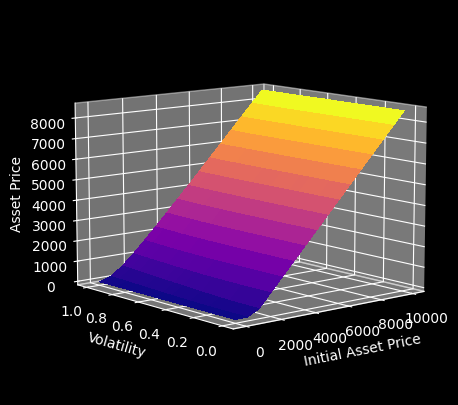

In [86]:
plot_asset_prices(initial_stock_prices, volatilities, option_prices_meshgrid)